# Momentum methods

Recall that high learning rate allows the optimizer to overcome plateaus. However, this can result in oscillation. The intuition behind **momentum** is that if successive gradient steps point in different
directions, we should cancel off the directions that disagree. Moreover, if successive gradient steps point in similar directions, we
should go faster in that direction. Simply adding gradients can result in extreme step size, so exponential averaging using a parameter $0 \leq \beta < 1$ is used:

$$
\begin{aligned}
\boldsymbol{\mathsf{m}}^t &= \beta \, \boldsymbol{\mathsf{m}}^{t-1} + (1 - \beta) \, \nabla_{\boldsymbol{\Theta}}\, f(\boldsymbol{\Theta}^{t}) \\
\boldsymbol{\boldsymbol{\Theta}}^{t+1} &= \boldsymbol{\boldsymbol{\Theta}}^{t} - \eta \, \boldsymbol{\mathsf{m}}^{t}.
\end{aligned}
$$

Note that $\beta = 0$ is just regular GD.
In the following implementation, we add an extra parameter `momentum=0.0` to the `GD` class for $\beta$. Observe that the optimizer is now **stateful**[^1]: the attribute `self.m` stores the momentum vector $\boldsymbol{\mathsf{m}}^t$ above as a dictionary with parameter keys. We will set $\boldsymbol{\mathsf{m}}^0 = \boldsymbol{0}$ and $\boldsymbol{\Theta}^1 = \boldsymbol{\Theta}_{\text{init}}.$

In [1]:
from chapter import *

In [2]:
%%save

class GDM(OptimizerBase):
    def __init__(self, params, lr, momentum=0.0):
        super().__init__(params, lr)
        self.beta = momentum
        self.m = {p: torch.zeros_like(p.data) for p in self.params}

    def update_param(self, p):
        self.m[p] = self.beta * self.m[p] + (1 - self.beta) * p.grad
        p += -self.lr * self.m[p]

class GDM(OptimizerBase):
    def __init__(self, params, lr, momentum=0.0):
        super().__init__(params, lr)
        self.beta = momentum
        self.m = {p: torch.zeros_like(p.data) for p in self.params}

    def update_param(self, p):
        self.m[p] = self.beta * self.m[p] + (1 - self.beta) * p.grad
        p += -self.lr * self.m[p]

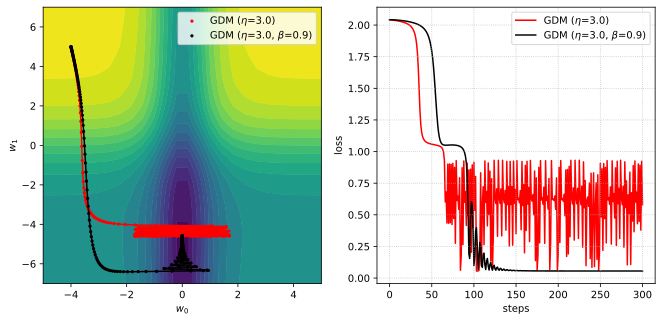

In [3]:
fig, ax = plt.subplots(1, 2, figsize=(11, 5))
label_map_gdm = {"lr": r"$\eta$", "momentum": r"$\beta$"}
plot_gd_steps(ax, optim=GDM, optim_params={"lr": 3.0},                  w_init=[-4.0, 5.0], label_map=label_map_gdm, color="red")
plot_gd_steps(ax, optim=GDM, optim_params={"lr": 3.0, "momentum": 0.9}, w_init=[-4.0, 5.0], label_map=label_map_gdm, color="black");

ax[0].set_xlim(-5, 5)
ax[0].set_ylim(-7, 7)
ax[1].set_xlabel("steps")
ax[1].set_ylabel("loss")
ax[1].grid(linestyle="dotted", alpha=0.8)
ax[0].legend()
ax[1].legend();

The optimizer is able to escape in initial plateau due to a high learning rate. 
Then, it overshoots resulting in delayed decrease in loss.
Between roughly 60-80 steps, the optimizer escapes the lower plateau
by accumulating small gradients toward the minimum.
Finally, it oscillates around the minimum but these eventually die down due to the effect of momentum.

**Remarks.** The parameter $\beta$ controls the effect of the previous update to the current update vector. A large momentum means that it maintains the previous state much more, while the gradient at the current point $(\boldsymbol{\Theta}^t, \mathcal{L}(\boldsymbol{\Theta^t}))$ has less effect on the update vector.

[^1]: Saving the `state_dict` for the optimizer and model in PyTorch allows to [resume training](https://pytorch.org/tutorials/beginner/saving_loading_models.html#saving-loading-a-general-checkpoint-for-inference-and-or-resuming-training).

## RMSProp

In vanilla GD, the magnitude of gradient is not very informative, only its *sign* is. 
Near the minimum it becomes small 
slowing down convergence, and on sharp slopes it can blow up the gradient vector. 
This makes it difficult to tune learning rate for different functions, or for different
points on the same function. To fix this, 
**RMSProp** normalizes the gradient along each dimension. 
It estimates the size of the gradient using exponential averaging with $\boldsymbol{\mathsf{v}}^0 = \mathbf{0}$ and $\boldsymbol{\Theta}^1 = \boldsymbol{\Theta}_{\text{init}}$:

$$
\begin{aligned}
\boldsymbol{\mathsf{v}}^t &= \beta \, \boldsymbol{\mathsf{v}}^{t-1} + (1 - \beta) \, \left( \nabla_{\boldsymbol{\Theta}}\, f(\boldsymbol{\Theta}^{t}) \right)^2 \\
\boldsymbol{\boldsymbol{\Theta}}^{t+1} &= \boldsymbol{\boldsymbol{\Theta}}^{t} - \eta \, \frac{1}{\sqrt{\boldsymbol{\mathsf{v}}^{t}}} \nabla_{\boldsymbol{\Theta}}\, f(\boldsymbol{\Theta}^{t}).
\end{aligned}
$$

In [4]:
%%save

class RMSProp(OptimizerBase):
    def __init__(self, params, lr, beta=0.9):
        super().__init__(params, lr)
        self.beta = beta
        self.v = {p: torch.zeros_like(p.data) for p in self.params}

    def update_param(self, p):
        self.v[p] = self.beta * self.v[p] + (1 - self.beta) * p.grad ** 2
        p += -self.lr * p.grad / torch.sqrt(self.v[p])

class RMSProp(OptimizerBase):
    def __init__(self, params, lr, beta=0.9):
        super().__init__(params, lr)
        self.beta = beta
        self.v = {p: torch.zeros_like(p.data) for p in self.params}

    def update_param(self, p):
        self.v[p] = self.beta * self.v[p] + (1 - self.beta) * p.grad ** 2
        p += -self.lr * p.grad / torch.sqrt(self.v[p])

Notice that gradient normalization allows escaping plateaus:

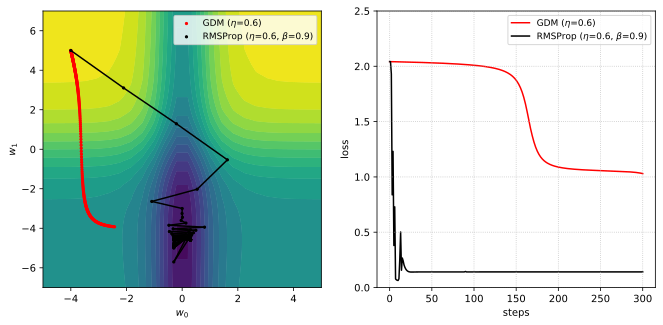

In [5]:
fig, ax = plt.subplots(1, 2, figsize=(11, 5))
label_map_rmsprop = {"lr": r"$\eta$", "beta": r"$\beta$"}
plot_gd_steps(ax, optim=GDM,     optim_params={"lr": 0.6},              w_init=[-4.0, 5.0], label_map=label_map_gdm,     color="red")
plot_gd_steps(ax, optim=RMSProp, optim_params={"lr": 0.6, "beta": 0.9}, w_init=[-4.0, 5.0], label_map=label_map_rmsprop, color="black")

ax[0].set_xlim(-5, 5)
ax[0].set_ylim(-7, 7)
ax[1].set_xlabel("steps")
ax[1].set_ylabel("loss")
ax[1].grid(linestyle="dotted", alpha=0.8)
ax[0].legend(fontsize=9)
ax[1].set_ylim(0, 2.5)
ax[1].legend(fontsize=9);

Note that the initial step size is ${\eta} \, {({1 - \beta})^{-1/2}} \geq \eta$ in each direction. Later on, if the gradient is smaller than previous gradients, then the step size suddenly becomes small. This can be seen near the minimum. Conversely, if the gradient is larger than previous gradients, then $\frac{1}{\sqrt{\boldsymbol{\mathsf{v}}^{t}}} \nabla_{\boldsymbol{\Theta}}\, f(\boldsymbol{\Theta}^{t})$ is large. This again can be observed in the latter part of the training, after the steps become small in the minimum. 

**Remark.** RMSProp have erratic properties, nevertheless it exhibits **adaptive learning rates**. That is, it looks like regular gradient descent but with dynamic effective learning rate in each parameter direction. Adam discussed next uses this and improves upon the defects of RMSProp.

## Adam

Observe in the above figure that RMSProp oscillates around the minimum. **Adam** {cite}`adam` fixes this by combining momentum with RMSProp. Adam uses bias correction so that gradients dominate during early stages of training, instead of the state vectors which are initially set to zero, these will have less  influence as training progresses. Let $0 \leq \beta_1 < 1$, $0 \leq \beta_2 < 1$, and $0 < \epsilon \ll 1.$ Set $\boldsymbol{\mathsf{m}}^0 = \boldsymbol{\mathsf{v}}^0  = \mathbf{0}$ and $\boldsymbol{\Theta}^1 = \boldsymbol{\Theta}_{\text{init}}.$ Starting with $t = 1$:

$$
\begin{aligned}
\boldsymbol{\mathsf{m}}^t &= \beta_1 \, \boldsymbol{\mathsf{m}}^{t-1} + (1 - \beta_1) \, \nabla_{\boldsymbol{\Theta}}\, f(\boldsymbol{\Theta}^{t}) \\
\boldsymbol{\mathsf{v}}^t &= \beta_2 \, \boldsymbol{\mathsf{v}}^{t-1} + (1 - \beta_2) \, \left( \nabla_{\boldsymbol{\Theta}}\, f(\boldsymbol{\Theta}^{t}) \right)^2 \\
\hat{\boldsymbol{\mathsf{m}}}^t &= \frac{\boldsymbol{\mathsf{m}}^t}{1 - {\beta_1}^t} \\
\hat{\boldsymbol{\mathsf{v}}}^t &= \frac{\boldsymbol{\mathsf{v}}^t}{1 - {\beta_2}^t} \\
\boldsymbol{\boldsymbol{\Theta}}^{t+1} &= \boldsymbol{\boldsymbol{\Theta}}^{t} - \eta \, \frac{1}{\sqrt{\hat{\boldsymbol{\mathsf{v}}}^{t}} + \epsilon} \cdot \hat{\boldsymbol{\mathsf{m}}}^t.
\end{aligned}
$$

The set of parameters is $\eta = 0.001$, $\beta_1 = 0.9$, $\beta_2 = 0.999$ and $\epsilon = 10^{-8}$ is a good starting point. Here $\beta_2 > \beta_1$ is chosen since gradient magnitude typically does not change as fast as its direction. Note that similar to RMSProp, the effective update size auto-tunes, so that the learning rate $\eta$ is roughly indicative of the update size.

**Bias correction.** Let $\boldsymbol{\mathsf{g}}^t = \nabla_{\boldsymbol{\Theta}}\, f(\boldsymbol{\Theta}^{t}).$ Note that time $t = 1$ corresponds to the initial point in the loss surface where $\boldsymbol{\mathsf{g}}^1 = \nabla_{\boldsymbol{\Theta}}\, f(\boldsymbol{\Theta}_{\text{init}})$. This also means that $t$ is the number of gradients that are summed when computing the exponential average. Observe that 

$$
\begin{aligned}
\boldsymbol{\mathsf{m}}^1
&= (1 - \beta_1)\, \boldsymbol{\mathsf{g}}^1\\\\
\boldsymbol{\mathsf{m}}^2
&= \beta_1\, \boldsymbol{\mathsf{m}}^1 + (1 - \beta_1)\, \boldsymbol{\mathsf{g}}^2 \\
&= \beta_1\, (1 - \beta_1)\, \boldsymbol{\mathsf{g}}^1 + (1 - \beta_1)\, \boldsymbol{\mathsf{g}}^2\\
&= (1 - \beta_1) \left({\beta_1}\,\boldsymbol{\mathsf{g}}^1 + \boldsymbol{\mathsf{g}}^2 \right).\\\\
\boldsymbol{\mathsf{m}}^3 
&= \beta_1\, \boldsymbol{\mathsf{m}}^2 + (1 - \beta_1)\, \boldsymbol{\mathsf{g}}^3 \\
&= \beta_1\, (1 - \beta_1)\,(\beta_1  \, \boldsymbol{\mathsf{g}}^1 +  \, \boldsymbol{\mathsf{g}}^2) + (1 - \beta_1)\, \boldsymbol{\mathsf{g}}^3\\
&= (1 - \beta_1) \left({\beta_1}^2 \boldsymbol{\mathsf{g}}^1 + {\beta_1}\, \boldsymbol{\mathsf{g}}^2 + \boldsymbol{\mathsf{g}}^3 \right).\\
\end{aligned}
$$

This slows down training at early steps where the terms in the sum are few, so that $\boldsymbol{\mathsf{m}}^t$ is small. Recall that $(1 - {\beta_1}^{3}) = (1 - {\beta_1}) \sum_{t = 0}^2 {\beta_1}^t.$ Dividing with this gets us a proper average that is biased towards recent gradients:

$$
\begin{aligned}
\hat{\boldsymbol{\mathsf{m}}}^3 &= \frac{{\beta_1}^2 \boldsymbol{\mathsf{g}}^1 + {\beta_1}\, \boldsymbol{\mathsf{g}}^2 + \boldsymbol{\mathsf{g}}^3}{{\beta_1}^2 + {\beta_1} + 1}.\\
\end{aligned}
$$

This calculation extends inductively. For $t = 1$, $\boldsymbol{\mathsf{m}}^1 = (1 - \beta_1)\,\boldsymbol{\mathsf{g}}^1$ whereas with bias correction we get $\hat{\boldsymbol{\mathsf{m}}}^1 = \boldsymbol{\mathsf{g}}^1.$ The following implementation gets this right with `self.t = 1` at the initial point where we apply the first update step. Note that bias correction in momentum only works because of the auto-learning rate tuning with $1 / \sqrt{\hat{\boldsymbol{\mathsf{v}}}^t}$. Otherwise, the optimizer rolls down a slope too fast, missing the minimum!

<br>

In [6]:
%%save

class Adam(OptimizerBase):
    def __init__(self, params, lr=0.001, beta1=0.9, beta2=0.999, eps=1e-8):
        super().__init__(params, lr)
        self.beta1 = beta1
        self.beta2 = beta2
        self.t = 0
        self.m = {p: torch.zeros_like(p.data) for p in self.params}
        self.v = {p: torch.zeros_like(p.data) for p in self.params}
        self.eps = eps

    @torch.no_grad()
    def step(self):
        """Increment global time for each optimizer step."""
        self.t += 1
        OptimizerBase.step(self)

    def update_param(self, p):
        self.m[p] = self.beta1 * self.m[p] + (1 - self.beta1) * p.grad
        self.v[p] = self.beta2 * self.v[p] + (1 - self.beta2) * p.grad ** 2
        m_hat = self.m[p] / (1 - self.beta1 ** self.t)
        v_hat = self.v[p] / (1 - self.beta2 ** self.t)
        p += -self.lr * m_hat / (torch.sqrt(v_hat) + self.eps)

class Adam(OptimizerBase):
    def __init__(self, params, lr=0.001, beta1=0.9, beta2=0.999, eps=1e-8):
        super().__init__(params, lr)
        self.beta1 = beta1
        self.beta2 = beta2
        self.t = 0
        self.m = {p: torch.zeros_like(p.data) for p in self.params}
        self.v = {p: torch.zeros_like(p.data) for p in self.params}
        self.eps = eps

    @torch.no_grad()
    def step(self):
        """Increment global time for each optimizer step."""
        self.t += 1
        OptimizerBase.step(self)

    def update_param(self, p):
        self.m[p] = self.beta1 * self.m[p] + (1 - self.beta1) * p.grad
        self.v[p] = self.beta2 * self.v[p] + (1 - self.beta2) * p.grad ** 2
        m_hat = self.m[p] / (1 - self.beta1 ** self.t)
        v_hat = self.v[p] / (1 - self.beta2 ** self.t)
        p += -self.lr * m_hat / (torch.sqrt(v_hat) + self.eps)

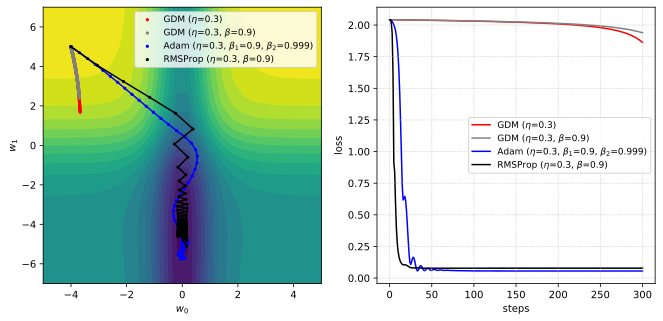

In [7]:
fig, ax = plt.subplots(1, 2, figsize=(11, 5))
label_map_adam = {"lr": r"$\eta$", "beta1": r"$\beta_1$", "beta2": r"$\beta_2$"}
plot_gd_steps(ax, optim=GDM,     optim_params={"lr": 0.3},                               w_init=[-4.0, 5.0], label_map=label_map_gdm,     color="red")
plot_gd_steps(ax, optim=GDM,     optim_params={"lr": 0.3, "momentum": 0.9},              w_init=[-4.0, 5.0], label_map=label_map_gdm,     color="gray")
plot_gd_steps(ax, optim=Adam,    optim_params={"lr": 0.3, "beta1": 0.9, "beta2": 0.999}, w_init=[-4.0, 5.0], label_map=label_map_adam,    color="blue")
plot_gd_steps(ax, optim=RMSProp, optim_params={"lr": 0.3, "beta": 0.9},                  w_init=[-4.0, 5.0], label_map=label_map_rmsprop, color="black")

ax[0].set_xlim(-5, 5)
ax[0].set_ylim(-7, 7)
ax[1].set_xlabel("steps")
ax[1].set_ylabel("loss")
ax[1].grid(linestyle="dotted", alpha=0.8)
ax[0].legend(fontsize=9)
ax[1].legend(fontsize=9);

The effect of momentum in Adam can be seen by the dampening of oscillations. Observe that for RMSProp, the oscillations do not die out near the minimum. Moreover, at the start of training where gradient updates do not cancel out, Adam has a step size of $\eta$ in each direction. Then adaptive learning rate helps to regulate the step size as the gradient tends to zero around the minimum.

Trying out a larger learning rate:

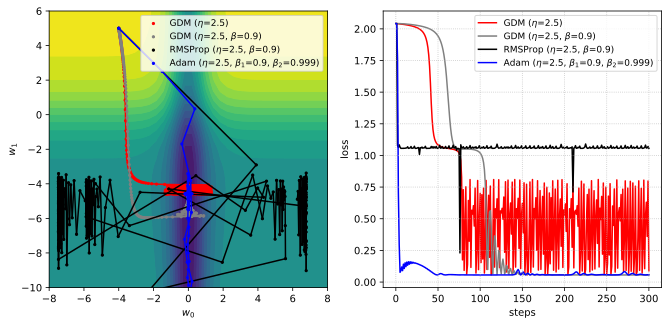

In [8]:
fig, ax = plt.subplots(1, 2, figsize=(11, 5))
plot_gd_steps(ax, optim=GDM,     optim_params={"lr": 2.5},                               w_init=[-4.0, 5.0], label_map=label_map_gdm,     color="red")
plot_gd_steps(ax, optim=GDM,     optim_params={"lr": 2.5, "momentum": 0.9},              w_init=[-4.0, 5.0], label_map=label_map_gdm,     color="grey")
plot_gd_steps(ax, optim=RMSProp, optim_params={"lr": 2.5, "beta": 0.9},                  w_init=[-4.0, 5.0], label_map=label_map_rmsprop, color="black")
plot_gd_steps(ax, optim=Adam,    optim_params={"lr": 2.5, "beta1": 0.9, "beta2": 0.999}, w_init=[-4.0, 5.0], label_map=label_map_adam,    color="blue")

ax[0].set_xlim(-8, 8)
ax[0].set_ylim(-10, 6)
ax[1].set_xlabel("steps")
ax[1].set_ylabel("loss")
ax[1].grid(linestyle="dotted", alpha=0.8)
ax[0].legend(fontsize=9)
ax[1].legend(fontsize=9);

Adam converges faster than GD since the update step, like RMSProp, is not as dependent on the magnitude of the gradient. However, the loss with Adam fluctuates a bit near the end of training. This can be attributed to the oscillations changing orientation, since the step size does not stabilize to zero. This is consistent with folk knowledge that SGD with momentum (see below), if tuned well and given enough time to converge, performs better than Adam. This is discussed further below.

**Remark.** Note that the gradient is coupled with the averaging technique in Adam. If we include regularization or weight decay in the loss, this means weight decay is likewise coupled. This is fixed in **AdamW** {cite}`adamw` which adjusts the weight decay term to appear in the gradient update:

$$
\boldsymbol{\boldsymbol{\Theta}}^{t+1} = \boldsymbol{\boldsymbol{\Theta}}^{t} 
- \eta \, 
\left( 
    \frac{\hat{\boldsymbol{\mathsf{m}}}^t}{\sqrt{\hat{\boldsymbol{\mathsf{v}}}^{t}} + \epsilon}
    + \lambda \,\boldsymbol{\Theta}^{t}
\right)
$$

where $\lambda$ is the **weight decay** coefficient. See [AdamW implementation](https://pytorch.org/docs/stable/generated/torch.optim.AdamW.html) in PyTorch.